# Dollar Cost Averaging (DCA) vs Lump Sum (LS)

> If you had 100K cash available in your bank and you are thinking of investing in a market index like the [S&P500](https://en.wikipedia.org/wiki/S%26P_500), then should you invest it 10K for the next 10 months or 100K today?

If you are thinking of this question, then congratulations! You are one step ahead than most who would simply jump on the bandwagon and follow mainstream advice. 

We can rarely be certain about one choice over another in practice but we can gain confidence if we apply a rigorous analytical approach to our decision. Here, we look to test two investment strategies, for a fixed amount of 100K on S&P500:

1. **Dollar Cost Averaging** (DCA)
2. **Lump Sum** (LS)

These strategies will be tested over the following parameters:

- **A large number of historical timepoints**: Such that the analysis can be generalized and answer probabilistic questions
- **Length of investment period**: 1, 3, 5, 10, 15, 20, 30 years
- **DCA periods**: What are the effects of investing, say 10K for 10 months vs 1K for 100 months (~8-9 years)?

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf

sns.set_theme(style="ticks", palette="pastel")
pd.options.display.float_format = "{:,.2f}".format

/Users/legendarryl/opt/anaconda3/envs/moneybags/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Close
Date,
1993-01-29 00:00:00-05:00,24.68
1993-02-01 00:00:00-05:00,24.86
1993-02-02 00:00:00-05:00,24.91
1993-02-03 00:00:00-05:00,25.18
1993-02-04 00:00:00-05:00,25.28


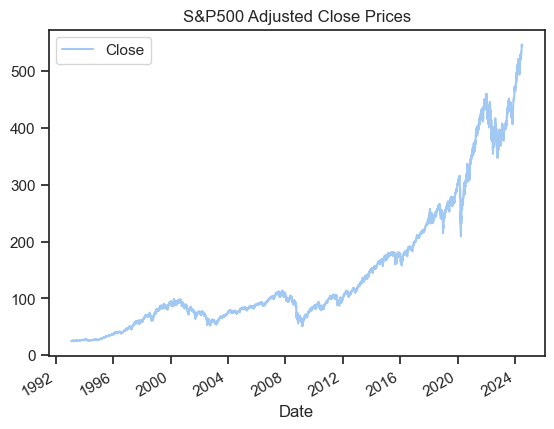

In [2]:
# Read S&P historical adjusted prices
ticker = 'SPY'
sp500 = (
    yf
    .Ticker(ticker)
    .history(period = 'max')
    # .reset_index()
    .loc[:, ['Close']]
)

# Check data
display(sp500.head())
sp500.plot(title = 'S&P500 Adjusted Close Prices')
plt.show()

In [3]:
# For backtest purposes, we fill non-working days with last prices
backtest_df = (    
    pd
    .DataFrame(index = pd.date_range(sp500.index.min(), sp500.index.max()))
    .rename_axis('Date')
    .merge(sp500, left_index = True, right_index = True, how = 'left')
    .ffill()
)

## Analyze

In [4]:
# Parameters
timepoints = backtest_df.index.to_numpy()
starting_cash = 100000
bootstraps = 1000
investment_periods = [1, 3, 5, 10, 15, 20] # in years
dca_periods = np.arange(1, 5+1, 4)*12 # DCA periods for 1 year vs 5 years

In [5]:
def invest(prices, invest_dates, amount):
    df = prices.copy()
    df.loc[lambda x: x.index.isin(invest_dates), 'invested'] = float(amount) / float(len(invest_dates)) # Invest equal amounts
    return df

def compute_returns(df, starting_cash):
    absolute_return = (df.invested * (1 + prices.returns)).sum() - starting_cash
    end_cash = starting_cash + absolute_return
    relative_return = (df.invested * (1 + prices.returns)).sum() / starting_cash - 1

    return [end_cash, absolute_return, relative_return]

In [6]:
# Backtest
results = []
for investment_period in investment_periods:
    for _ in range(bootstraps):
        # Get key points
        max_start_point = timepoints.max() - pd.DateOffset(years = investment_period)
        possible_start_points = timepoints[timepoints <= max_start_point]
        start_point = np.random.choice(possible_start_points)
        end_point = start_point + pd.DateOffset(years = investment_period)

        # Get prices
        prices = (
            backtest_df
            .loc[lambda x: (x.index >= start_point) & (x.index <= end_point)]
            .assign(
                returns = lambda x: x.iloc[-1].Close / x.Close - 1,
                invested = 0.00,
            )
            .copy()
        )

        # Invest lump-sum
        lump_sum = invest(prices, [start_point], starting_cash)

        # Compute returns
        ls_returns = compute_returns(lump_sum, starting_cash)

        # Store results
        results.append([start_point, end_point, investment_period, 'LS', starting_cash,] + ls_returns)

        # Invest DCA
        dcas = []
        for dca_period in dca_periods:
            invest_dates = pd.date_range(start_point, start_point + pd.DateOffset(months = dca_period), freq = 'BME')
            dca = invest(prices, invest_dates, starting_cash)
            dca_returns = compute_returns(dca, starting_cash)
            results.append([start_point, end_point, investment_period, f'DCA{dca_period}', starting_cash, ] + dca_returns)

In [7]:
# Store results
backtest = (
    pd
    .DataFrame(
        np.array(results), 
        columns = ['start_date', 'end_date', 'years', 'strategy', 'start_cash', 'end_cash', 'abs_return', 'pct_return'],
    )
)

## Evaluate

/var/folders/m0/k7y1900n6hq1zl76ryv_l9040000gn/T/ipykernel_14128/1728119485.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


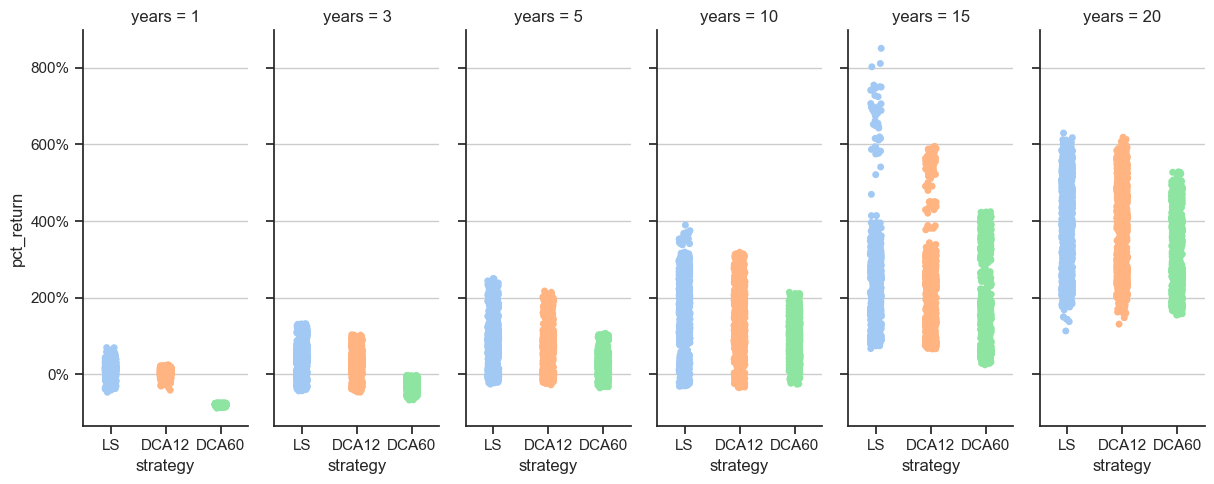

In [8]:
# Compare by investment years and strategy
g = sns.catplot(data = backtest, x = 'strategy', y = 'pct_return', hue = 'strategy', col = 'years', aspect = 0.4)

# Set grid and y-axis to percentage
for i, ax in enumerate(g.axes.flatten()):
    ax.grid(visible = True, axis = 'y')
    if i == 0:
        labels = [f'{x:.0%}' for x in ax.get_yticks()]
        ax.set_yticklabels(labels)

plt.show()

In [9]:
# Report statistics
confidence = 99
(
    backtest
    .groupby(['strategy', 'years'])
    .agg(
        {
            'pct_return': ['mean', 'min', 'max', lambda x: np.percentile(x, 100-confidence), lambda x: np.percentile(x, confidence)]
        }
    )
    .reset_index()
    .set_axis(['strategy', 'years', 'x_return', 'min', 'max', f'{100-confidence}%', f'{confidence}%'], axis = 1)
    .pivot_table(index = 'years', columns = 'strategy', values = ['x_return', '1%', '99%'])
    + 1
) * starting_cash

1%                              99%                        \
strategy      DCA12      DCA60         LS      DCA12      DCA60         LS   
years                                                                        
1         76,091.59  15,301.71  63,706.07 121,705.05  24,618.93 149,794.62   
3         61,572.65  40,073.73  63,755.00 198,393.19  94,821.37 225,672.89   
5         79,581.31  69,932.33  81,708.68 302,021.68 200,868.65 334,081.33   
10        74,385.35  84,625.13  78,381.94 409,016.21 305,980.21 458,520.34   
15       171,931.01 132,938.37 180,777.60 684,127.17 513,772.49 824,317.24   
20       271,988.08 265,022.86 280,636.67 689,004.54 603,289.68 702,733.84   

           x_return                        
strategy      DCA12      DCA60         LS  
years                                      
1        105,661.66  21,166.49 111,141.83  
3        132,156.53  71,424.69 139,118.54  
5        161,964.56 131,038.83 170,411.65  
10       232,101.89 192,052.45 244,212.56  
15       311,635.48 279,259.47 320,417.22  
20       468,820.70 398,538.01 488,041.19